In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os
from numba import cuda 
plt.style.use("science.mplstyle")
import pickle 

from helpers.synthesis import *
from helpers.visualization import *


dpi = 800

In [2]:
# fixed 
project_id = "wide"
gen_seed = 3
results_dir = f"/global/ml4hep/spss/rrmastandrea/synth_SM_AD/NF_results_{project_id}_seed_{gen_seed}/"

n_sig_inj = [0, 300, 500, 750, 1000, 1200, 1500, 2000, 2500, 3000]
n_sig_inj_SR = [0, 226, 376, 565, 753, 904, 1130, 1506, 1883, 2260]
n_sig_inj = [0, 300, 500, 750, 1000, 1200, 1500]
n_sig_inj_SR = [0, 226, 376, 565, 753, 904, 1130]

n_seed = 14
num_bkg = 320000
num_sig = 20000

rerun = True

# Load in


In [5]:
process = "None" #StandardScale
keys = ["feta","cathode", "curtains", "salad", "combined", "full_sup", "combined_scores"]

methods_to_avg = ["feta", "cathode", "curtains", "salad"]


n_avg = 2 # number of classifiers to average the scores over
n_trials_post_avg = int(n_seed / n_avg)
rejection_for_sic = 1000 # for showing the SIC at a fixed background rejection

# truth labels
y_test = np.concatenate((torch.zeros((num_bkg, 1)), torch.ones((num_sig,1))))

#x_axis = np.logspace(-8, 0, 400)
x_axis = np.linspace(1e-5, 1, 100)

# initialize dictionaries
rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}                
sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
max_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
sic_at_rej_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
auc_dict = {k:{n:[] for n in n_sig_inj} for k in keys}

In [6]:
if rerun:
    for n in n_sig_inj:

        print(f"Working on n_sig = {n}...")

        # load in the scores data for a given signal injection
        all_results_bkg, all_results_sig = load_in_data(n, num_bkg, process,
                                                    keys[:-1], n_seed, gen_seed,results_dir)
        for k in keys:
            if k != "combined_scores":

                for jump in range(0, n_seed, n_avg): 
                    seeds_to_avg = np.arange(jump, jump + n_avg)

                    # average every n_avg scores
                    averaged_scores_bkg = np.average([all_results_bkg[k][s] for s in seeds_to_avg], axis = 0)
                    averaged_scores_sig = np.average([all_results_sig[k][s] for s in seeds_to_avg], axis = 0)

                    outputs = np.concatenate((averaged_scores_bkg, averaged_scores_sig))

                    interp_rej, interp_sic, maxsic, sic_at_rejection, loc_auc = scores_into_summary(outputs, y_test, x_axis, num_bkg, rejection_for_sic)

                    rejections_dict[k][n].append(interp_rej)
                    sics_dict[k][n].append(interp_sic)
                    max_sics_dict[k][n].append(maxsic)
                    sic_at_rej_dict[k][n].append(sic_at_rejection)
                    auc_dict[k][n].append(loc_auc)

            elif k == "combined_scores": # combined samples: average the scores across the four methods
                for jump in range(0, n_seed, n_avg): 
                    seeds_to_avg = np.arange(jump, jump + n_avg)

                    to_avg_bkg = []
                    to_avg_sig = []
                    for s in seeds_to_avg:
                        for m in methods_to_avg:
                            to_avg_bkg.append(all_results_bkg[m][s])
                            to_avg_sig.append(all_results_sig[m][s])

                    # average every n_avg scores
                    averaged_scores_bkg = np.average(to_avg_bkg, axis = 0)
                    averaged_scores_sig = np.average(to_avg_sig, axis = 0)

                    # get the roc
                    outputs = np.concatenate((averaged_scores_bkg, averaged_scores_sig))

                    interp_rej, interp_sic, maxsic, sic_at_rejection, loc_auc = scores_into_summary(outputs, y_test, x_axis, num_bkg, rejection_for_sic)

                    rejections_dict[k][n].append(interp_rej)
                    sics_dict[k][n].append(interp_sic)
                    max_sics_dict[k][n].append(maxsic)
                    sic_at_rej_dict[k][n].append(sic_at_rejection)
                    auc_dict[k][n].append(loc_auc)

    print("Done!")

Working on n_sig = 0...
Working on n_sig = 300...
Working on n_sig = 500...
Working on n_sig = 750...
Working on n_sig = 1000...
Working on n_sig = 1200...
Working on n_sig = 1500...
Done!


# Take the median / get errorbands

In [7]:
# initialize dictionaries
med_rejections_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
med_sics_dict = {k:{n:[] for n in n_sig_inj} for k in keys}
med_max_sics_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys} # mean, lower_p, upper_p
med_sics_at_rej_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys}
med_aucs_dict = {k:[np.array([]),np.array([]),np.array([])] for k in keys}


for n in n_sig_inj:
    
    for k in keys:
        

        med_rejections_dict[k][n] = get_med_percentile(rejections_dict[k][n])
        med_sics_dict[k][n] = get_med_percentile(sics_dict[k][n])
                 
        # max sic sic at rejection are single numbers, not arrays
        med_max_sics_dict[k][0] = np.append(med_max_sics_dict[k][0], np.median(max_sics_dict[k][n]))
        med_max_sics_dict[k][1] = np.append(med_max_sics_dict[k][1], np.percentile(max_sics_dict[k][n], 16)) 
        med_max_sics_dict[k][2] = np.append(med_max_sics_dict[k][2], np.percentile(max_sics_dict[k][n], 84))        
            
        med_sics_at_rej_dict[k][0] = np.append(med_sics_at_rej_dict[k][0], np.median(sic_at_rej_dict[k][n]))
        med_sics_at_rej_dict[k][1] = np.append(med_sics_at_rej_dict[k][1], np.percentile(sic_at_rej_dict[k][n], 16))
        med_sics_at_rej_dict[k][2] = np.append(med_sics_at_rej_dict[k][2], np.percentile(sic_at_rej_dict[k][n], 84))
        
        med_aucs_dict[k][0] = np.append(med_aucs_dict[k][0], np.median(auc_dict[k][n]))
        med_aucs_dict[k][1] = np.append(med_aucs_dict[k][1], np.percentile(auc_dict[k][n], 16))
        med_aucs_dict[k][2] = np.append(med_aucs_dict[k][2], np.percentile(auc_dict[k][n], 84))
                        

In [8]:
print(med_aucs_dict)

{'feta': [array([0.64346234, 0.68524485, 0.80146276, 0.80027456, 0.84925268,
       0.81950382, 0.82654467]), array([0.56203809, 0.63403465, 0.76070628, 0.77888495, 0.82630459,
       0.77663918, 0.82336032]), array([0.64736938, 0.70749964, 0.83219205, 0.81677701, 0.86000966,
       0.83216322, 0.83314557])], 'cathode': [array([0.77263289, 0.74710209, 0.77744204, 0.7977484 , 0.84153046,
       0.82055767, 0.82543464]), array([0.74335622, 0.72846397, 0.7172193 , 0.78507787, 0.82464531,
       0.81577114, 0.80433758]), array([0.80926671, 0.79937627, 0.7997073 , 0.83782115, 0.85477014,
       0.8304943 , 0.84633554])], 'curtains': [array([0.65228365, 0.58263262, 0.51629435, 0.68238136, 0.77612236,
       0.79679346, 0.8027733 ]), array([0.59478894, 0.51605317, 0.51414705, 0.54587472, 0.75437535,
       0.78425049, 0.79401353]), array([0.73461195, 0.59859824, 0.58336439, 0.72395056, 0.79175193,
       0.81286418, 0.80688998])], 'salad': [array([0.82079257, 0.55253433, 0.65944139, 0.8524984

In [ ]:
# save out
pickle.dump( med_rejections_dict, open( "pickles/sample_combo_med_rejections_dict.p", "wb" ) )
pickle.dump( med_sics_dict, open( "pickles/sample_combo_med_sics_dict.p", "wb" ) )
pickle.dump( med_max_sics_dict, open( "pickles/sample_combo_med_max_sics_dict.p", "wb" ) )
pickle.dump( med_sics_at_rej_dict, open( "pickles/sample_combo_med_sics_at_rej_dict.p", "wb" ) )

In [ ]:
# load in
med_rejections_dict = pickle.load(open( "pickles/sample_combo_med_rejections_dict.p", "rb" ) )
med_sics_dict = pickle.load(open( "pickles/sample_combo_med_sics_dict.p", "rb" ) )
med_max_sics_dict = pickle.load(open( "pickles/sample_combo_med_max_sics_dict.p", "rb" ) )
med_sics_at_rej_dict = pickle.load(open( "pickles/sample_combo_med_sics_at_rej_dict.p", "rb" ) )
                   

In [9]:

colors_dict = {"full_sup":"grey",
               "salad": "#009E73",
               "feta": "#CC79A7",
               "cathode":"#D55E00",
               "curtains":"#E69F00",
                "combined": "#e41a1c",
               "combined_scores": "#0072B2",
                "ideal_ad":"#56B4E9"}

labels_dict = {"full_sup":"Fully Supervised",
               "salad": "SALAD",
               "feta": "FETA",
               "cathode":"CATHODE",
               "curtains":"CURTAINs",
                "combined": "Combined (Events)",
               "combined_scores": "Combined (Scores)",
              "ideal_ad": "Ideal. AD"}

hatches_dict = {"full_sup":"Full. Sup. ",
               "salad": "\\",
               "feta": "/",
               "cathode":"-",
               "curtains":"|",
                "combined": "++",
            "combined_scores": "++"}


l = 3
f_1 = 20
f_2 = 30
alpha = 0.4
num_bkg_in_SR = 121339

keys_to_plot = ["feta","cathode", "curtains", "salad", "combined", "combined_scores", "full_sup"]
#keys_to_plot = ["feta","cathode", "curtains", "salad"]


# Summary plots

## Max sic

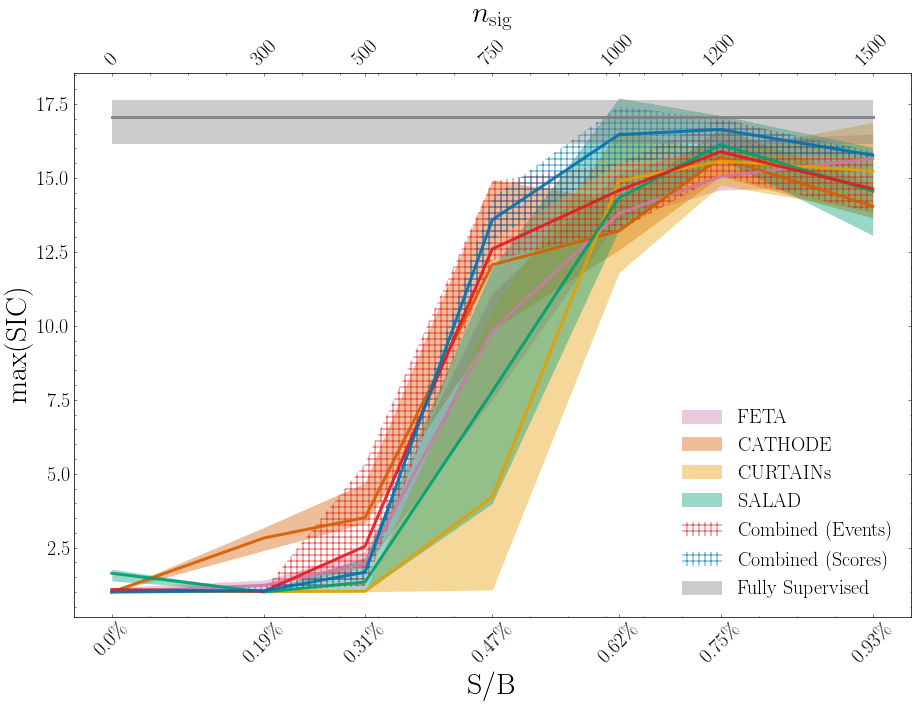

In [10]:
x_vals = [n / num_bkg_in_SR for n in n_sig_inj_SR]

fig = plt.figure(figsize = (15, 10)) 

ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()


for k in keys_to_plot:

    
   
    ax1.plot(x_vals, med_max_sics_dict[k][0], color = colors_dict[k], linewidth = l, alpha = alpha + 0.5)
    #plt.fill_between(x_vals, mean_max_sics_dict[k][0] -mean_max_sics_dict[k][1],
    #                    mean_max_sics_dict[k][0] + mean_max_sics_dict[k][1],
     #                    alpha = alpha, color = colors_dict[k], linewidth = 0)
        
    if (k == "combined") or (k == "combined_scores"):
        ax1.fill_between(x_vals, med_max_sics_dict[k][1],
                            med_max_sics_dict[k][2],
                             alpha = alpha+.3, facecolor = "none", edgecolor = colors_dict[k], 
                         linewidth = 0, hatch = hatches_dict[k], label = labels_dict[k])
    else:
        ax1.fill_between(x_vals, med_max_sics_dict[k][1],
                            med_max_sics_dict[k][2],
                             alpha = alpha, color = colors_dict[k], 
                         linewidth = 0, label = labels_dict[k])
        

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(x_vals)
ax2.set_xticklabels(n_sig_inj, size=f_1, rotation = 45)
ax2.set_xlabel(r"$n_\mathrm{sig}$", fontsize = f_2, labelpad = 10)

ax1.set_xticks(x_vals)
ax1.set_xticklabels([f"{np.round(100*x, 2)}\%" for x in x_vals], size=f_1, rotation = 45)
ax1.set_xlabel("S/B", fontsize = f_2)

ax1.legend(fontsize = f_1, loc = "lower right")

ax1.set_ylabel("max(SIC)", fontsize = f_2)
ax1.tick_params(axis='both', which='major', labelsize=f_1)
#fig.savefig(f"plots/maxsic_methods_only.pdf", dpi = dpi)

plt.show()

## SIC at rej

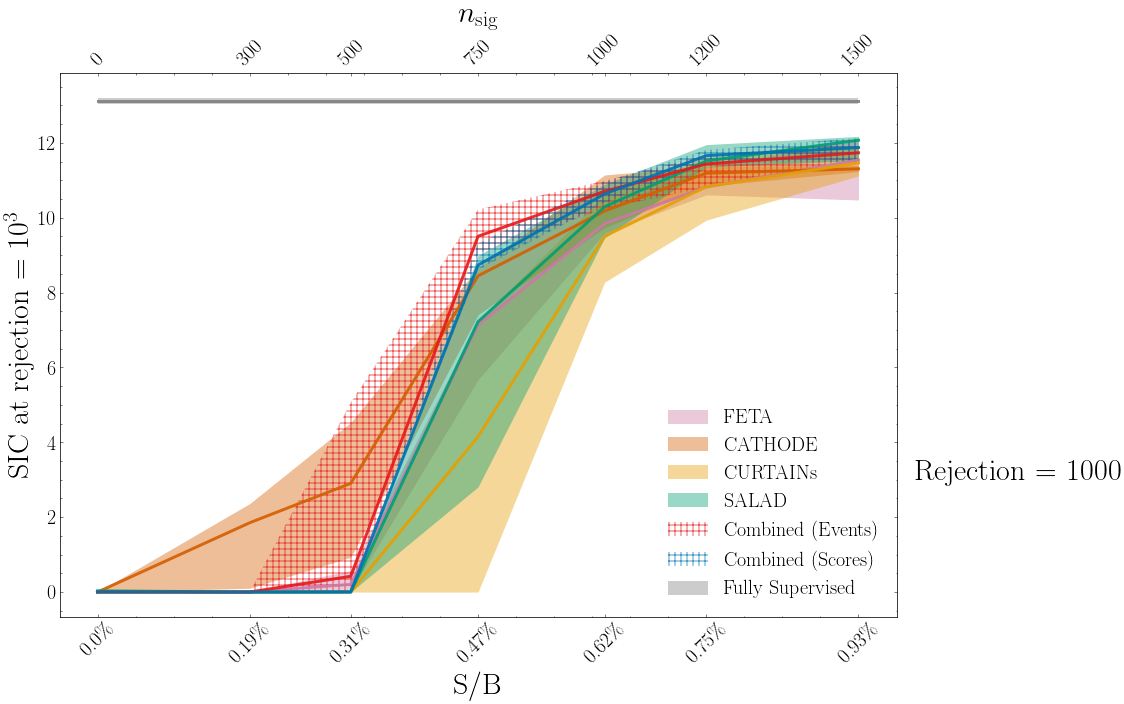

In [11]:


x_vals = [n / num_bkg_in_SR for n in n_sig_inj_SR]


fig = plt.figure(figsize = (15, 10)) 

ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()


for k in keys_to_plot:
    
   
    ax1.plot(x_vals, med_sics_at_rej_dict[k][0], color = colors_dict[k], linewidth = l, alpha = alpha + 0.5)


    if  (k == "combined") or (k == "combined_scores"):
        ax1.fill_between(x_vals, med_sics_at_rej_dict[k][1],
                            med_sics_at_rej_dict[k][2],
                             alpha = alpha+.3, facecolor = "none", edgecolor = colors_dict[k], 
                         linewidth = 0, hatch = hatches_dict[k], label = labels_dict[k])
    else:
        ax1.fill_between(x_vals, med_sics_at_rej_dict[k][1],
                            med_sics_at_rej_dict[k][2],
                             alpha = alpha, color = colors_dict[k], 
                         linewidth = 0, label = labels_dict[k])
        


ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(x_vals)
ax2.set_xticklabels(n_sig_inj, size=f_1, rotation = 45)
ax2.set_xlabel(r"$n_\mathrm{sig}$", fontsize = f_2, labelpad = 10)


ax1.set_xticks(x_vals)
ax1.set_xticklabels([f"{np.round(100*x, 2)}\%" for x in x_vals], size=f_1, rotation = 45)
ax1.set_xlabel("S/B", fontsize = f_2)

plt.text(.01, 3, f"Rejection = {rejection_for_sic}", fontsize = f_2)

ax1.legend(fontsize = f_1, loc = "lower right")

ax1.set_ylabel("SIC at rejection = $10^3$", fontsize = f_2)
ax1.tick_params(axis='both', which='major', labelsize=f_1)
#fig.savefig(f"plots/sic_at_rej.pdf", dpi = dpi)

plt.show()





In [12]:
for i, n in enumerate(n_sig_inj_SR):
    
    significance = n / np.sqrt(num_bkg_in_SR)
    
    print(n, med_max_sics_dict["feta"][0][i]*significance)
    

0 0.0
226 0.7958121945900922
376 2.112213735081477
565 15.977180789568912
753 29.831803685584436
904 39.05752547349286
1130 50.796530612227386


# Individual nsig plots

## SIC

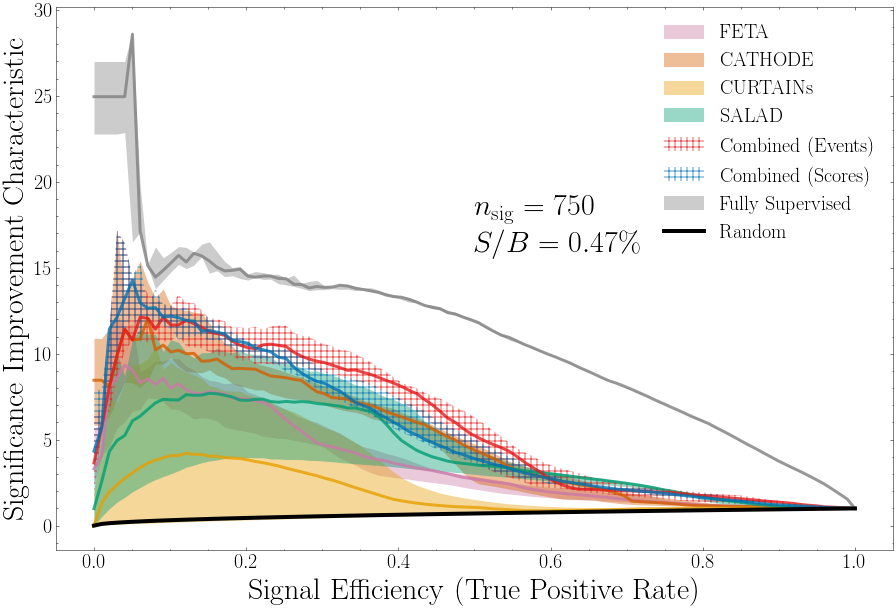

In [13]:
n_to_plot = [750]

for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10))

    for k in keys_to_plot:
        
        
        plt.plot(x_axis, med_sics_dict[k][n][0], color = colors_dict[k], linewidth = l, alpha = alpha + 0.4)

   
        
        if  (k == "combined") or (k == "combined_scores"):
            plt.fill_between(x_axis, med_sics_dict[k][n][1],
                            med_sics_dict[k][n][2],
                             alpha = alpha+.3, facecolor = "none", edgecolor = colors_dict[k], 
                         linewidth = 0, hatch = hatches_dict[k], label = labels_dict[k])
        else:
                plt.fill_between(x_axis, med_sics_dict[k][n][1],
                            med_sics_dict[k][n][2],
                             alpha = alpha, color = colors_dict[k], 
                         linewidth = 0, label = labels_dict[k])
  

    plt.plot(x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black", linewidth = l+1)
    
    ind = n_sig_inj.index(n)
    
    text = "n_\mathrm{sig}"
    
    plt.text(0.5, 16, f"${text} = {n}$\n$S/B = {np.round(100*n_sig_inj_SR[ind]/num_bkg_in_SR, 2)}\%$", fontsize = f_2)
    #plt.ylim(0, 25)
    """
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 4, 1, 2, 3]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize = f_1)
    """
    
    plt.legend(fontsize = f_1)
    
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f_2)    
    plt.ylabel("Significance Improvement Characteristic", fontsize = f_2)
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    
    fig.savefig(f"plots/sic_{n}.pdf", dpi = dpi)
    
    plt.show()

## Rejection

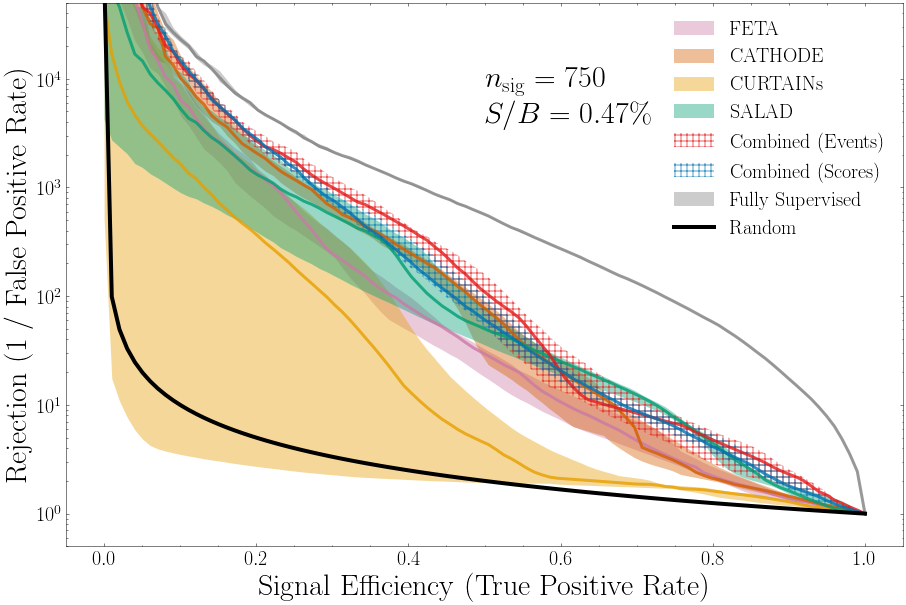

In [14]:
for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10)) 
    for k in keys_to_plot:
        
      
        plt.plot(x_axis, med_rejections_dict[k][n][0], color = colors_dict[k], linewidth = l, alpha = alpha + 0.4)

        if  (k == "combined") or (k == "combined_scores"):
            plt.fill_between(x_axis, med_rejections_dict[k][n][1],
                            med_rejections_dict[k][n][2],
                             alpha = alpha+.3, facecolor = "none", edgecolor = colors_dict[k], 
                         linewidth = 0, hatch = hatches_dict[k], label = labels_dict[k])
        else:
                plt.fill_between(x_axis, med_rejections_dict[k][n][1],
                            med_rejections_dict[k][n][2],
                             alpha = alpha, color = colors_dict[k], 
                         linewidth = 0, label = labels_dict[k])

    plt.plot(x_axis, 1.0/x_axis, label = "Random", color = "black", linewidth = l+1)
    
    ind = n_sig_inj.index(n)
    text = "n_\mathrm{sig}"
    plt.text(0.5, 4000, f"${text} = {n}$\n$S/B = {np.round(100*n_sig_inj_SR[ind]/num_bkg_in_SR, 2)}\%$", fontsize = f_2)

    """
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 4, 1, 2, 3]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize = f_1)  
    """   
    plt.legend(fontsize = f_1)  

    
    plt.ylim(5e-1, 5e4)
    plt.yscale("log")
    plt.xlabel("Signal Efficiency (True Positive Rate)", fontsize = f_2)  
    plt.ylabel("Rejection (1 / False Positive Rate)", fontsize = f_2)  
    #plt.title(f"Num injected events: {n}")
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    
    fig.savefig(f"plots/rej_{n}.pdf", dpi = dpi)

    plt.show()

## SIC vs rej

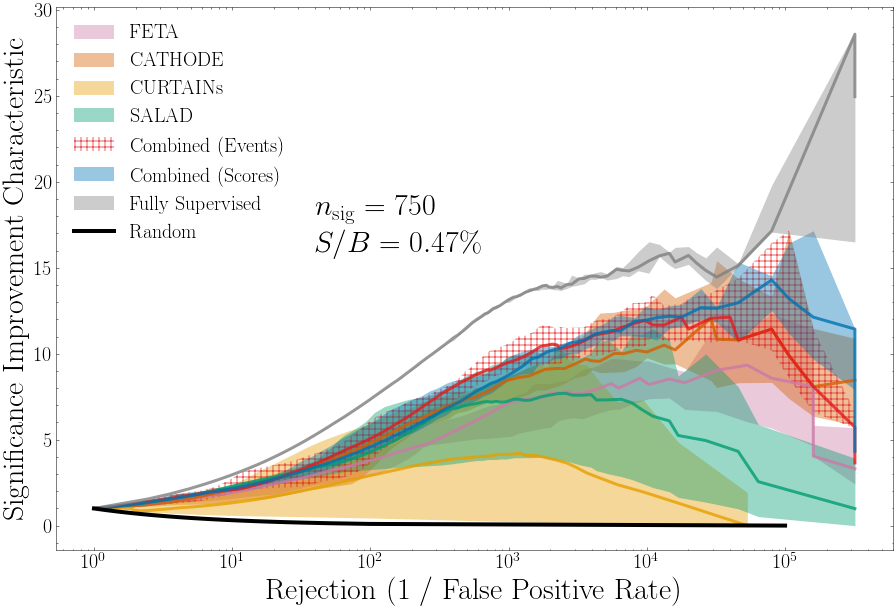

In [15]:
for n in n_to_plot:

    fig = plt.figure(figsize = (15, 10)) 
    for k in keys_to_plot:
        

        plt.plot(med_rejections_dict[k][n][0], med_sics_dict[k][n][0], color = colors_dict[k], linewidth = l, alpha = alpha + 0.4)

        if k == "combined":
            plt.fill_between(med_rejections_dict[k][n][0], med_sics_dict[k][n][1],
                            med_sics_dict[k][n][2],
                             alpha = alpha+.3, facecolor = "none", edgecolor = colors_dict[k], 
                         linewidth = 0, hatch = hatches_dict[k], label = labels_dict[k])
        else:
                plt.fill_between(med_rejections_dict[k][n][0], med_sics_dict[k][n][1],
                            med_sics_dict[k][n][2],
                             alpha = alpha, color = colors_dict[k], 
                         linewidth = 0, label = labels_dict[k])

    plt.plot(1.0/x_axis, x_axis/np.sqrt(x_axis), label = "Random", color = "black", linewidth = l+1)
    
    
    ind = n_sig_inj.index(n)
    text = "n_\mathrm{sig}"
    plt.text(40, 16, f"${text} = {n}$\n$S/B = {np.round(100*n_sig_inj_SR[ind]/num_bkg_in_SR, 2)}\%$", fontsize = f_2)
    
    """
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [0, 4, 1, 2, 3]
    plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize = f_1)
    """

    plt.legend(fontsize = f_1)
    plt.xscale("log")
    plt.xlabel("Rejection (1 / False Positive Rate)", fontsize = f_2)  
    plt.ylabel("Significance Improvement Characteristic", fontsize = f_2)
    plt.tick_params(axis='both', which='major', labelsize=f_1)
    fig.savefig(f"plots/sic_vs_rej_{n}.pdf", dpi = dpi)
    


    plt.show()